In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashishjstar/lettuce-diseases")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/lettuce-diseases


In [4]:
import os
import random
import numpy as np
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
from torchvision.transforms import functional as TF
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# -----------------
# CONFIG
# -----------------
SEED = 42
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# -----------------
# DATA PREPROCESSING
# -----------------

def resize_and_pad(img, size=IMG_SIZE):
    if isinstance(img, torch.Tensor):
        img = TF.to_pil_image(img)  # convert back to PIL
    
    w, h = img.size
    scale = size / max(w, h)
    new_w, new_h = int(w * scale), int(h * scale)

    img = TF.resize(img, (new_h, new_w))
    pad_w, pad_h = size - new_w, size - new_h
    padding = (pad_w // 2, pad_h // 2, pad_w - pad_w // 2, pad_h - pad_h // 2)
    img = TF.pad(img, padding, fill=0)  # black padding
    return img  # still PIL
    
class ResizePad:
    def __call__(self, img):
        return resize_and_pad(img, IMG_SIZE)

# Base transform (no augmentation)
base_transform = transforms.Compose([
    ResizePad(),
    transforms.ToTensor(),
])

# Augmentation for unhealthy classes
aug_transform = transforms.Compose([
    ResizePad(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

# -----------------
# LOAD DATASET
# -----------------
DATA_DIR = "/kaggle/input/lettuce-diseases/Lettuce_disease_datasets"
dataset = datasets.ImageFolder(DATA_DIR, transform=base_transform)
class_names = dataset.classes
print("Classes:", class_names)
# Map classes
healthy_idx = class_names.index("Healthy")
weed_idx = class_names.index("Shepherd_purse_weeds")
disease_indices = [i for i, c in enumerate(class_names) if c not in ["Healthy", "Shepherd_purse_weeds"]]

# Train-test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# -----------------
# FILTERED DATASETS
# -----------------
class FilteredDataset(torch.utils.data.Dataset):
    def __init__(self, subset, include_classes, binary=False, target_map=None, transform=None):
        self.subset = subset
        self.include_classes = include_classes
        self.binary = binary
        self.target_map = target_map
        self.transform = transform

        self.indices = [i for i, (img, label) in tqdm(enumerate(self.subset)) if label in include_classes]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        img, label = self.subset[real_idx]
        if self.transform:
            img = self.transform(img)
        if self.binary and self.target_map:
            label = self.target_map[label]
        return img, label

# Classifier 1: Crop vs Weed (binary)
train_ds1 = FilteredDataset(train_dataset, include_classes=list(range(len(class_names))),
                            binary=True, target_map={weed_idx:0, healthy_idx:1, **{d:1 for d in disease_indices}},
                            transform=base_transform)

# Classifier 2: Healthy vs Not Healthy (binary, augment unhealthy)
train_ds2_healthy = FilteredDataset(train_dataset, include_classes=[healthy_idx],
                                    binary=True, target_map={healthy_idx:1}, transform=base_transform)
train_ds2_unhealthy = FilteredDataset(train_dataset, include_classes=disease_indices,
                                      binary=True, target_map={d:0 for d in disease_indices}, transform=aug_transform)

train_ds2 = torch.utils.data.ConcatDataset([train_ds2_healthy, train_ds2_unhealthy])

# Classifier 3: Disease multiclass (6 classes)
train_ds3 = FilteredDataset(train_dataset, include_classes=disease_indices,
                            binary=False, target_map=None, transform=aug_transform)

# Test datasets (use base transform)
test_ds1 = FilteredDataset(test_dataset, include_classes=list(range(len(class_names))),
                           binary=True, target_map={weed_idx:0, healthy_idx:1, **{d:1 for d in disease_indices}},
                           transform=base_transform)
test_ds2 = FilteredDataset(test_dataset, include_classes=[healthy_idx] + disease_indices,
                           binary=True, target_map={healthy_idx:1, **{d:0 for d in disease_indices}},
                           transform=base_transform)
test_ds3 = FilteredDataset(test_dataset, include_classes=disease_indices,
                           binary=False, target_map=None, transform=base_transform)

# DataLoaders
train_loader1 = DataLoader(train_ds1, batch_size=BATCH_SIZE, shuffle=True)
train_loader2 = DataLoader(train_ds2, batch_size=BATCH_SIZE, shuffle=True)
train_loader3 = DataLoader(train_ds3, batch_size=BATCH_SIZE, shuffle=True)

test_loader1 = DataLoader(test_ds1, batch_size=BATCH_SIZE, shuffle=False)
test_loader2 = DataLoader(test_ds2, batch_size=BATCH_SIZE, shuffle=False)
test_loader3 = DataLoader(test_ds3, batch_size=BATCH_SIZE, shuffle=False)

test_loader_full = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -----------------
# MODEL DEFINITIONS
# -----------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# -----------------
# LOSSES
# -----------------
class WeightedAsymmetricLoss(nn.Module):
    def __init__(self, weight=None, gamma_pos=1, gamma_neg=4):
        super().__init__()
        self.weight = weight
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg

    def forward(self, logits, targets):
        if logits.size(1) == 1:
            targets = targets.float().unsqueeze(1)
        else:
            targets = F.one_hot(targets, num_classes=logits.size(1)).float().to(logits.device)
        prob = torch.sigmoid(logits)
        pos_loss = -targets * ((1 - prob) ** self.gamma_pos) * torch.log(prob + 1e-8)
        neg_loss = -(1 - targets) * (prob ** self.gamma_neg) * torch.log(1 - prob + 1e-8)
        loss = pos_loss + neg_loss
        if self.weight is not None:
            loss = loss * self.weight
        return loss.mean()

# -----------------
# TRAINING FUNCTION
# -----------------
def train_model(model, train_loader, criterion, optimizer, epochs=EPOCHS):
    model.to(DEVICE)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(imgs)
            if outputs.size(1) == 1:
                loss = criterion(outputs, labels.unsqueeze(1).float())
            else:
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")
    return model

# -----------------
# CLASSIFIERS
# -----------------
model1 = SimpleCNN(num_classes=1)
criterion1 = nn.BCEWithLogitsLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=1e-3)

model2 = SimpleCNN(num_classes=1)
criterion2 = WeightedAsymmetricLoss()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3)

model3 = SimpleCNN(num_classes=6)
criterion3 = WeightedAsymmetricLoss()
optimizer3 = torch.optim.Adam(model3.parameters(), lr=1e-3)

# -----------------
# FINAL EVALUATION (Confusion Matrix on 8 classes)
# -----------------
def evaluate(models, test_loader):
    model1, model2, model3 = models
    y_true, y_pred = [], []

    model1.eval(); model2.eval(); model3.eval()
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(DEVICE)
            labels = labels.numpy()

            out1 = torch.sigmoid(model1(imgs)).cpu().numpy().ravel()
            is_crop = out1 > 0.5

            for i in range(len(labels)):
                if not is_crop[i]:
                    y_pred.append(weed_idx)
                else:
                    out2 = torch.sigmoid(model2(imgs[i:i+1])).cpu().item()
                    if out2 > 0.5:
                        y_pred.append(healthy_idx)
                    else:
                        out3 = model3(imgs[i:i+1])
                        pred_class = torch.argmax(out3, dim=1).cpu().item()
                        disease_class = disease_indices[pred_class]
                        y_pred.append(disease_class)
                y_true.append(labels[i])

    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45)
    plt.show()

model1 = train_model(model1, train_loader1, criterion1, optimizer1)
model2 = train_model(model2, train_loader2, criterion2, optimizer2)
model3 = train_model(model3, train_loader3, criterion3, optimizer3)
evaluate((model1, model2, model3), test_loader_full)


Classes: ['Bacterial', 'Downy_mildew_on_lettuce', 'Healthy', 'Powdery_mildew_on_lettuce', 'Septoria_blight_on_lettuce', 'Shepherd_purse_weeds', 'Viral', 'Wilt_and_leaf_blight_on_lettuce']


1869it [01:36, 19.45it/s]
1869it [01:35, 19.49it/s]
1869it [01:35, 19.50it/s]
1869it [01:35, 19.52it/s]
468it [00:23, 20.23it/s]
468it [00:23, 20.20it/s]
468it [00:23, 20.33it/s]


Epoch 1/10, Loss: 0.1690
Epoch 2/10, Loss: 0.0551
Epoch 3/10, Loss: 0.0442
Epoch 4/10, Loss: 0.0261
Epoch 5/10, Loss: 0.0231
Epoch 7/10, Loss: 0.0192
Epoch 8/10, Loss: 0.0231
Epoch 9/10, Loss: 0.0325
Epoch 10/10, Loss: 0.0184
Epoch 1/10, Loss: 0.1801
Epoch 2/10, Loss: 0.1040
Epoch 3/10, Loss: 0.1025
Epoch 4/10, Loss: 0.1020
Epoch 5/10, Loss: 0.1015
Epoch 6/10, Loss: 0.1012
Epoch 7/10, Loss: 0.1020
Epoch 8/10, Loss: 0.1006
Epoch 9/10, Loss: 0.1069
Epoch 10/10, Loss: 0.1039


RuntimeError: Class values must be smaller than num_classes.

Using device: cpu
Classes: ['Bacterial', 'Downy_mildew_on_lettuce', 'Healthy', 'Powdery_mildew_on_lettuce', 'Septoria_blight_on_lettuce', 'Shepherd_purse_weeds', 'Viral', 'Wilt_and_leaf_blight_on_lettuce']
Total samples: 2337
  Bacterial: 20 samples
  Downy_mildew_on_lettuce: 30 samples
  Healthy: 1123 samples
  Powdery_mildew_on_lettuce: 18 samples
  Septoria_blight_on_lettuce: 19 samples
  Shepherd_purse_weeds: 1106 samples
  Viral: 15 samples
  Wilt_and_leaf_blight_on_lettuce: 6 samples

Healthy class index: 2
Weed class index: 5
Disease indices: [0, 1, 3, 4, 6, 7]
Disease names: ['Bacterial', 'Downy_mildew_on_lettuce', 'Powdery_mildew_on_lettuce', 'Septoria_blight_on_lettuce', 'Viral', 'Wilt_and_leaf_blight_on_lettuce']

Train size: 1869, Test size: 468

CREATING DATASETS

Classifier 1: Crop vs Weed


Filtering dataset: 1869it [01:13, 25.55it/s]



Classifier 2: Healthy vs Diseased


Filtering dataset: 1869it [01:13, 25.44it/s]
Filtering dataset: 1869it [01:13, 25.50it/s]



Classifier 3: Disease Classification


Filtering dataset: 1869it [01:13, 25.51it/s]


Sequential mapping: {0: 0, 1: 1, 3: 2, 4: 3, 6: 4, 7: 5}


Filtering dataset: 468it [00:17, 27.22it/s]
Filtering dataset: 468it [00:17, 27.04it/s]
Filtering dataset: 468it [00:17, 26.90it/s]


Sequential mapping: {0: 0, 1: 1, 3: 2, 4: 3, 6: 4, 7: 5}

Dataset sizes:
  Train DS1 (Crop vs Weed): 1869
  Train DS2 (Healthy vs Disease): 992
  Train DS3 (Disease Classification): 88
  Test DS1: 468
  Test DS2: 239
  Test DS3: 20

INITIALIZING MODELS
Model 1 (Crop vs Weed): Binary classifier initialized
Model 2 (Healthy vs Disease): Binary classifier initialized
Model 3 (Disease Classification): 6-class classifier initialized

TRAINING MODEL 1 (Crop vs Weed)


Epoch 1/10: 100%|██████████| 59/59 [04:02<00:00,  4.11s/it, Loss=0.2082, Acc=91.97%]


Epoch 1/10 - Loss: 0.2476, Accuracy: 0.9197


Epoch 2/10: 100%|██████████| 59/59 [04:15<00:00,  4.33s/it, Loss=0.0184, Acc=98.61%]


Epoch 2/10 - Loss: 0.0522, Accuracy: 0.9861


Epoch 3/10: 100%|██████████| 59/59 [03:50<00:00,  3.91s/it, Loss=0.0756, Acc=98.88%]


Epoch 3/10 - Loss: 0.0371, Accuracy: 0.9888


Epoch 4/10: 100%|██████████| 59/59 [03:47<00:00,  3.86s/it, Loss=0.0064, Acc=98.82%]


Epoch 4/10 - Loss: 0.0363, Accuracy: 0.9882


Epoch 5/10: 100%|██████████| 59/59 [04:07<00:00,  4.20s/it, Loss=0.0003, Acc=98.98%]


Epoch 5/10 - Loss: 0.0291, Accuracy: 0.9898


Epoch 6/10: 100%|██████████| 59/59 [04:00<00:00,  4.08s/it, Loss=0.0006, Acc=99.57%]


Epoch 6/10 - Loss: 0.0139, Accuracy: 0.9957


Epoch 7/10: 100%|██████████| 59/59 [03:45<00:00,  3.82s/it, Loss=0.0089, Acc=99.63%]


Epoch 7/10 - Loss: 0.0107, Accuracy: 0.9963


Epoch 8/10: 100%|██████████| 59/59 [04:09<00:00,  4.23s/it, Loss=0.0030, Acc=98.93%]


Epoch 8/10 - Loss: 0.0248, Accuracy: 0.9893


Epoch 9/10: 100%|██████████| 59/59 [04:11<00:00,  4.27s/it, Loss=0.0000, Acc=99.68%]


Epoch 9/10 - Loss: 0.0131, Accuracy: 0.9968


Epoch 10/10: 100%|██████████| 59/59 [04:11<00:00,  4.27s/it, Loss=0.0002, Acc=99.89%]


Epoch 10/10 - Loss: 0.0044, Accuracy: 0.9989

MODEL 1 (Crop vs Weed) training completed!

TRAINING MODEL 2 (Healthy vs Disease)


Epoch 1/10: 100%|██████████| 31/31 [02:45<00:00,  5.33s/it, Loss=0.1418, Acc=91.13%]


Epoch 1/10 - Loss: 0.1671, Accuracy: 0.9113


Epoch 2/10: 100%|██████████| 31/31 [02:44<00:00,  5.31s/it, Loss=0.0912, Acc=91.13%]


Epoch 2/10 - Loss: 0.1126, Accuracy: 0.9113


Epoch 3/10: 100%|██████████| 31/31 [02:40<00:00,  5.17s/it, Loss=0.0868, Acc=91.13%]


Epoch 3/10 - Loss: 0.1072, Accuracy: 0.9113


Epoch 4/10: 100%|██████████| 31/31 [02:55<00:00,  5.65s/it, Loss=0.1225, Acc=91.13%]


Epoch 4/10 - Loss: 0.1043, Accuracy: 0.9113


Epoch 5/10: 100%|██████████| 31/31 [02:26<00:00,  4.73s/it, Loss=0.1046, Acc=91.13%]


Epoch 5/10 - Loss: 0.1054, Accuracy: 0.9113


Epoch 6/10: 100%|██████████| 31/31 [02:27<00:00,  4.76s/it, Loss=0.1596, Acc=91.13%]


Epoch 6/10 - Loss: 0.1051, Accuracy: 0.9113


Epoch 7/10: 100%|██████████| 31/31 [02:27<00:00,  4.76s/it, Loss=0.1163, Acc=91.13%]


Epoch 7/10 - Loss: 0.1078, Accuracy: 0.9113


Epoch 8/10: 100%|██████████| 31/31 [03:05<00:00,  5.98s/it, Loss=0.0838, Acc=91.13%]


Epoch 8/10 - Loss: 0.1079, Accuracy: 0.9113


Epoch 9/10: 100%|██████████| 31/31 [02:42<00:00,  5.23s/it, Loss=0.1042, Acc=91.13%]


Epoch 9/10 - Loss: 0.1045, Accuracy: 0.9113


Epoch 10/10: 100%|██████████| 31/31 [02:37<00:00,  5.09s/it, Loss=0.0903, Acc=91.13%]


Epoch 10/10 - Loss: 0.1090, Accuracy: 0.9113

MODEL 2 (Healthy vs Disease) training completed!

TRAINING MODEL 3 (Disease Classification)


Epoch 1/10: 100%|██████████| 3/3 [00:09<00:00,  3.08s/it, Loss=0.1970, Acc=20.45%]


Epoch 1/10 - Loss: 0.2228, Accuracy: 0.2045


Epoch 2/10: 100%|██████████| 3/3 [00:09<00:00,  3.10s/it, Loss=0.0929, Acc=13.64%]


Epoch 2/10 - Loss: 0.1026, Accuracy: 0.1364


Epoch 3/10: 100%|██████████| 3/3 [00:09<00:00,  3.09s/it, Loss=0.0932, Acc=27.27%]


Epoch 3/10 - Loss: 0.0923, Accuracy: 0.2727


Epoch 4/10: 100%|██████████| 3/3 [00:09<00:00,  3.26s/it, Loss=0.0927, Acc=28.41%]


Epoch 4/10 - Loss: 0.0924, Accuracy: 0.2841


Epoch 5/10: 100%|██████████| 3/3 [00:10<00:00,  3.53s/it, Loss=0.0921, Acc=28.41%]


Epoch 5/10 - Loss: 0.0923, Accuracy: 0.2841


Epoch 6/10: 100%|██████████| 3/3 [00:09<00:00,  3.08s/it, Loss=0.0895, Acc=30.68%]


Epoch 6/10 - Loss: 0.0908, Accuracy: 0.3068


Epoch 7/10: 100%|██████████| 3/3 [00:09<00:00,  3.06s/it, Loss=0.0943, Acc=27.27%]


Epoch 7/10 - Loss: 0.0929, Accuracy: 0.2727


Epoch 8/10: 100%|██████████| 3/3 [00:09<00:00,  3.08s/it, Loss=0.0907, Acc=29.55%]


Epoch 8/10 - Loss: 0.0905, Accuracy: 0.2955


Epoch 9/10: 100%|██████████| 3/3 [00:09<00:00,  3.09s/it, Loss=0.0893, Acc=27.27%]


Epoch 9/10 - Loss: 0.0905, Accuracy: 0.2727


Epoch 10/10: 100%|██████████| 3/3 [00:09<00:00,  3.07s/it, Loss=0.0923, Acc=30.68%]


Epoch 10/10 - Loss: 0.0908, Accuracy: 0.3068

MODEL 3 (Disease Classification) training completed!

INDIVIDUAL MODEL EVALUATION

Model 1 (Crop vs Weed) Performance:
  Accuracy: 0.9936 (465/468)
  Classification Report:
              precision    recall  f1-score   support

    Negative     0.9871    1.0000    0.9935       229
    Positive     1.0000    0.9874    0.9937       239

    accuracy                         0.9936       468
   macro avg     0.9935    0.9937    0.9936       468
weighted avg     0.9937    0.9936    0.9936       468


Model 2 (Healthy vs Disease) Performance:
  Accuracy: 0.9163 (219/239)
  Classification Report:
              precision    recall  f1-score   support

    Negative     0.0000    0.0000    0.0000        20
    Positive     0.9163    1.0000    0.9563       219

    accuracy                         0.9163       239
   macro avg     0.4582    0.5000    0.4782       239
weighted avg     0.8396    0.9163    0.8763       239



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif


Model 3 (Disease Classification) Performance:
  Accuracy: 0.2500 (5/20)
  Classification Report:
                                 precision    recall  f1-score   support

                      Bacterial     0.0000    0.0000    0.0000         3
        Downy_mildew_on_lettuce     0.2500    1.0000    0.4000         5
      Powdery_mildew_on_lettuce     0.0000    0.0000    0.0000         3
     Septoria_blight_on_lettuce     0.0000    0.0000    0.0000         4
                          Viral     0.0000    0.0000    0.0000         4
Wilt_and_leaf_blight_on_lettuce     0.0000    0.0000    0.0000         1

                       accuracy                         0.2500        20
                      macro avg     0.0417    0.1667    0.0667        20
                   weighted avg     0.0625    0.2500    0.1000        20


TRAINING AND EVALUATION COMPLETE

HIERARCHICAL SYSTEM EVALUATION


Evaluating hierarchical system: 100%|██████████| 15/15 [00:42<00:00,  2.80s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_star


Overall System Accuracy: 0.9573

Detailed Classification Report:
                                 precision    recall  f1-score   support

                      Bacterial     0.0000    0.0000    0.0000         3
        Downy_mildew_on_lettuce     0.0000    0.0000    0.0000         5
                        Healthy     0.9280    1.0000    0.9626       219
      Powdery_mildew_on_lettuce     0.0000    0.0000    0.0000         3
     Septoria_blight_on_lettuce     0.0000    0.0000    0.0000         4
           Shepherd_purse_weeds     0.9871    1.0000    0.9935       229
                          Viral     0.0000    0.0000    0.0000         4
Wilt_and_leaf_blight_on_lettuce     0.0000    0.0000    0.0000         1

                       accuracy                         0.9573       468
                      macro avg     0.2394    0.2500    0.2445       468
                   weighted avg     0.9172    0.9573    0.9366       468



<Figure size 1200x1000 with 0 Axes>

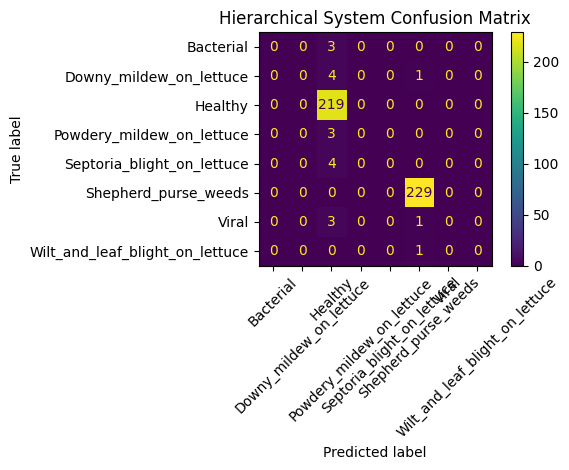


SUMMARY
Model 1 (Crop vs Weed) Accuracy: 0.9936
Model 2 (Healthy vs Disease) Accuracy: 0.9163
Model 3 (Disease Classification) Accuracy: 0.2500
Overall Hierarchical System Accuracy: 0.9573


In [5]:
import os
import random
import numpy as np
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
from torchvision.transforms import functional as TF
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

# -----------------
# CONFIG
# -----------------
SEED = 42
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# -----------------
# DATA PREPROCESSING
# -----------------

def resize_and_pad(img, size=IMG_SIZE):
    if isinstance(img, torch.Tensor):
        img = TF.to_pil_image(img)  # convert back to PIL
    
    w, h = img.size
    scale = size / max(w, h)
    new_w, new_h = int(w * scale), int(h * scale)

    img = TF.resize(img, (new_h, new_w))
    pad_w, pad_h = size - new_w, size - new_h
    padding = (pad_w // 2, pad_h // 2, pad_w - pad_w // 2, pad_h - pad_h // 2)
    img = TF.pad(img, padding, fill=0)  # black padding
    return img  # still PIL
    
class ResizePad:
    def __call__(self, img):
        return resize_and_pad(img, IMG_SIZE)

# Base transform (no augmentation)
base_transform = transforms.Compose([
    ResizePad(),
    transforms.ToTensor(),
])

# Augmentation for unhealthy classes
aug_transform = transforms.Compose([
    ResizePad(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

# -----------------
# LOAD DATASET
# -----------------
DATA_DIR = "/kaggle/input/lettuce-diseases/Lettuce_disease_datasets"
dataset = datasets.ImageFolder(DATA_DIR, transform=base_transform)
class_names = dataset.classes
print("Classes:", class_names)
print(f"Total samples: {len(dataset)}")

# Count samples per class
class_counts = Counter([dataset[i][1] for i in range(len(dataset))])
for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {class_counts[i]} samples")

# Map classes
healthy_idx = class_names.index("Healthy")
weed_idx = class_names.index("Shepherd_purse_weeds")
disease_indices = [i for i, c in enumerate(class_names) if c not in ["Healthy", "Shepherd_purse_weeds"]]
disease_names = [class_names[i] for i in disease_indices]

print(f"\nHealthy class index: {healthy_idx}")
print(f"Weed class index: {weed_idx}")
print(f"Disease indices: {disease_indices}")
print(f"Disease names: {disease_names}")

# Train-test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(f"\nTrain size: {train_size}, Test size: {test_size}")

# -----------------
# FILTERED DATASETS
# -----------------
class FilteredDataset(torch.utils.data.Dataset):
    def __init__(self, subset, include_classes, binary=False, target_map=None, transform=None, remap_to_sequential=False):
        self.subset = subset
        self.include_classes = include_classes
        self.binary = binary
        self.target_map = target_map
        self.transform = transform
        self.remap_to_sequential = remap_to_sequential

        self.indices = [i for i, (img, label) in tqdm(enumerate(self.subset), desc="Filtering dataset") if label in include_classes]
        
        # Create sequential mapping for disease classes if needed
        if self.remap_to_sequential and not self.binary:
            self.class_to_sequential = {cls: i for i, cls in enumerate(sorted(include_classes))}
            print(f"Sequential mapping: {self.class_to_sequential}")

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        img, label = self.subset[real_idx]
        if self.transform:
            img = self.transform(img)
        if self.binary and self.target_map:
            label = self.target_map[label]
        elif self.remap_to_sequential and not self.binary:
            label = self.class_to_sequential[label]
        return img, label

print("\n" + "="*50)
print("CREATING DATASETS")
print("="*50)

# Classifier 1: Crop vs Weed (binary)
print("\nClassifier 1: Crop vs Weed")
train_ds1 = FilteredDataset(train_dataset, include_classes=list(range(len(class_names))),
                            binary=True, target_map={weed_idx:0, healthy_idx:1, **{d:1 for d in disease_indices}},
                            transform=base_transform)

# Classifier 2: Healthy vs Not Healthy (binary, augment unhealthy)
print("\nClassifier 2: Healthy vs Diseased")
train_ds2_healthy = FilteredDataset(train_dataset, include_classes=[healthy_idx],
                                    binary=True, target_map={healthy_idx:1}, transform=base_transform)
train_ds2_unhealthy = FilteredDataset(train_dataset, include_classes=disease_indices,
                                      binary=True, target_map={d:0 for d in disease_indices}, transform=aug_transform)

train_ds2 = torch.utils.data.ConcatDataset([train_ds2_healthy, train_ds2_unhealthy])

# Classifier 3: Disease multiclass (6 classes) - FIXED: sequential mapping
print("\nClassifier 3: Disease Classification")
train_ds3 = FilteredDataset(train_dataset, include_classes=disease_indices,
                            binary=False, target_map=None, transform=aug_transform, remap_to_sequential=True)

# Test datasets (use base transform)
test_ds1 = FilteredDataset(test_dataset, include_classes=list(range(len(class_names))),
                           binary=True, target_map={weed_idx:0, healthy_idx:1, **{d:1 for d in disease_indices}},
                           transform=base_transform)
test_ds2 = FilteredDataset(test_dataset, include_classes=[healthy_idx] + disease_indices,
                           binary=True, target_map={healthy_idx:1, **{d:0 for d in disease_indices}},
                           transform=base_transform)
test_ds3 = FilteredDataset(test_dataset, include_classes=disease_indices,
                           binary=False, target_map=None, transform=base_transform, remap_to_sequential=True)

print(f"\nDataset sizes:")
print(f"  Train DS1 (Crop vs Weed): {len(train_ds1)}")
print(f"  Train DS2 (Healthy vs Disease): {len(train_ds2)}")
print(f"  Train DS3 (Disease Classification): {len(train_ds3)}")
print(f"  Test DS1: {len(test_ds1)}")
print(f"  Test DS2: {len(test_ds2)}")
print(f"  Test DS3: {len(test_ds3)}")

# DataLoaders
train_loader1 = DataLoader(train_ds1, batch_size=BATCH_SIZE, shuffle=True)
train_loader2 = DataLoader(train_ds2, batch_size=BATCH_SIZE, shuffle=True)
train_loader3 = DataLoader(train_ds3, batch_size=BATCH_SIZE, shuffle=True)

test_loader1 = DataLoader(test_ds1, batch_size=BATCH_SIZE, shuffle=False)
test_loader2 = DataLoader(test_ds2, batch_size=BATCH_SIZE, shuffle=False)
test_loader3 = DataLoader(test_ds3, batch_size=BATCH_SIZE, shuffle=False)

test_loader_full = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -----------------
# MODEL DEFINITIONS
# -----------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

# -----------------
# LOSSES
# -----------------
class WeightedAsymmetricLoss(nn.Module):
    def __init__(self, weight=None, gamma_pos=1, gamma_neg=4):
        super().__init__()
        self.weight = weight
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg

    def forward(self, logits, targets):
        if logits.size(1) == 1:
            targets = targets.float().unsqueeze(1)
        else:
            targets = F.one_hot(targets, num_classes=logits.size(1)).float().to(logits.device)
        prob = torch.sigmoid(logits)
        pos_loss = -targets * ((1 - prob) ** self.gamma_pos) * torch.log(prob + 1e-8)
        neg_loss = -(1 - targets) * (prob ** self.gamma_neg) * torch.log(1 - prob + 1e-8)
        loss = pos_loss + neg_loss
        if self.weight is not None:
            loss = loss * self.weight
        return loss.mean()

# -----------------
# EVALUATION FUNCTIONS
# -----------------
def evaluate_binary_model(model, test_loader, model_name):
    model.eval()
    y_true, y_pred = [], []
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            predictions = (torch.sigmoid(outputs) > 0.5).float().squeeze()
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
            
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)
    
    accuracy = total_correct / total_samples
    print(f"\n{model_name} Performance:")
    print(f"  Accuracy: {accuracy:.4f} ({total_correct}/{total_samples})")
    print(f"  Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive'], digits=4))
    
    return accuracy

def evaluate_multiclass_model(model, test_loader, model_name, class_names):
    model.eval()
    y_true, y_pred = [], []
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            predictions = torch.argmax(outputs, dim=1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
            
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)
    
    accuracy = total_correct / total_samples
    print(f"\n{model_name} Performance:")
    print(f"  Accuracy: {accuracy:.4f} ({total_correct}/{total_samples})")
    print(f"  Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    
    return accuracy

# -----------------
# TRAINING FUNCTION
# -----------------
def train_model(model, train_loader, criterion, optimizer, model_name, epochs=EPOCHS):
    print(f"\n" + "="*50)
    print(f"TRAINING {model_name}")
    print("="*50)
    
    model.to(DEVICE)
    train_losses = []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for imgs, labels in progress_bar:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(imgs)
            
            if outputs.size(1) == 1:
                loss = criterion(outputs, labels.unsqueeze(1).float())
                predictions = (torch.sigmoid(outputs) > 0.5).float().squeeze()
                correct += (predictions == labels).sum().item()
            else:
                loss = criterion(outputs, labels)
                predictions = torch.argmax(outputs, dim=1)
                correct += (predictions == labels).sum().item()
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total += labels.size(0)
            
            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
        
        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        train_losses.append(avg_loss)
        
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    
    print(f"\n{model_name} training completed!")
    return model

# -----------------
# CLASSIFIERS
# -----------------
print("\n" + "="*60)
print("INITIALIZING MODELS")
print("="*60)

model1 = SimpleCNN(num_classes=1)
criterion1 = nn.BCEWithLogitsLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=1e-3)
print("Model 1 (Crop vs Weed): Binary classifier initialized")

model2 = SimpleCNN(num_classes=1)
criterion2 = WeightedAsymmetricLoss()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3)
print("Model 2 (Healthy vs Disease): Binary classifier initialized")

model3 = SimpleCNN(num_classes=6)
criterion3 = WeightedAsymmetricLoss()
optimizer3 = torch.optim.Adam(model3.parameters(), lr=1e-3)
print("Model 3 (Disease Classification): 6-class classifier initialized")

# -----------------
# TRAINING
# -----------------
model1 = train_model(model1, train_loader1, criterion1, optimizer1, "MODEL 1 (Crop vs Weed)")
model2 = train_model(model2, train_loader2, criterion2, optimizer2, "MODEL 2 (Healthy vs Disease)")
model3 = train_model(model3, train_loader3, criterion3, optimizer3, "MODEL 3 (Disease Classification)")

# -----------------
# INDIVIDUAL MODEL EVALUATION
# -----------------
print("\n" + "="*60)
print("INDIVIDUAL MODEL EVALUATION")
print("="*60)

acc1 = evaluate_binary_model(model1, test_loader1, "Model 1 (Crop vs Weed)")
acc2 = evaluate_binary_model(model2, test_loader2, "Model 2 (Healthy vs Disease)")
acc3 = evaluate_multiclass_model(model3, test_loader3, "Model 3 (Disease Classification)", disease_names)

# -----------------
# FINAL EVALUATION (Confusion Matrix on 8 classes)
# -----------------
def evaluate_hierarchical_system(models, test_loader):
    print("\n" + "="*60)
    print("HIERARCHICAL SYSTEM EVALUATION")
    print("="*60)
    
    model1, model2, model3 = models
    y_true, y_pred = [], []
    
    # Create mapping from sequential indices back to original class indices
    sequential_to_original = {i: cls for i, cls in enumerate(sorted(disease_indices))}

    model1.eval()
    model2.eval() 
    model3.eval()
    
    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc="Evaluating hierarchical system"):
            imgs = imgs.to(DEVICE)
            labels = labels.numpy()

            out1 = torch.sigmoid(model1(imgs)).cpu().numpy().ravel()
            is_crop = out1 > 0.5

            for i in range(len(labels)):
                if not is_crop[i]:
                    y_pred.append(weed_idx)
                else:
                    out2 = torch.sigmoid(model2(imgs[i:i+1])).cpu().item()
                    if out2 > 0.5:
                        y_pred.append(healthy_idx)
                    else:
                        out3 = model3(imgs[i:i+1])
                        pred_class = torch.argmax(out3, dim=1).cpu().item()
                        disease_class = sequential_to_original[pred_class]
                        y_pred.append(disease_class)
                y_true.append(labels[i])

    # Calculate overall accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nOverall System Accuracy: {accuracy:.4f}")
    
    # Detailed classification report
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    plt.figure(figsize=(12, 10))
    disp.plot(xticks_rotation=45)
    plt.title("Hierarchical System Confusion Matrix")
    plt.tight_layout()
    plt.show()
    
    return accuracy

# -----------------
# FINAL RESULTS
# -----------------
print("\n" + "="*60)
print("TRAINING AND EVALUATION COMPLETE")
print("="*60)

final_accuracy = evaluate_hierarchical_system((model1, model2, model3), test_loader_full)

print(f"\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Model 1 (Crop vs Weed) Accuracy: {acc1:.4f}")
print(f"Model 2 (Healthy vs Disease) Accuracy: {acc2:.4f}")  
print(f"Model 3 (Disease Classification) Accuracy: {acc3:.4f}")
print(f"Overall Hierarchical System Accuracy: {final_accuracy:.4f}")
print("="*60)